In [9]:
#Evaluate
import numpy as np
import cv2
from tqdm import tqdm
import time
import signal

def timeout_handler(num, stack):
    raise Exception("TIMEOUT")

def evaluate(student_file = 'sample_student', 
             path_to_training_images = 'data/training/images',
             training_csv_file = 'data/training/steering_angles.csv', 
             path_to_testing_images = 'data/training/images',
             testing_csv_file = 'data/training/steering_angles.csv', 
             time_limit = 600):
    
    '''
    Evaluate Student Submission for autonomous driving challenge. 
    Train and test studen't neural network implementation. 
    Training time is limited to time_limit seconds, if your code takes 
    longer than this, it will be terminated and no score will be recorded.
    '''
    
    #Import student methods:
    train = getattr(__import__(student_file, 'train'), 'train')
    predict = getattr(__import__(student_file, 'predict'), 'predict')
    
    #Setup timout handler - I think this will only work on unix based systems:
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(time_limit)
    
    try:
        print("Training your network, start time: %s" % time.strftime("%H:%M:%S"))
        NN = train(path_to_images = path_to_training_images,
                   csv_file = training_csv_file)

    except ValueError as ex:
        pass
        
    finally:
        signal.alarm(0)
        print("Ending Time: %s" % time.strftime("%H:%M:%S"))
        
    print('Training Complete! \n')
    
    print('Measuring performance...')
    ## Measure Performance:
    data = np.genfromtxt(testing_csv_file, delimiter = ',')
    frame_nums = data[:,0]
    steering_angles = data[:,1]

    predicted_angles = []
    for frame_num in tqdm(frame_nums):
        im_path = path_to_testing_images + '/' + str(int(frame_num)).zfill(4) + '.jpg'
        predicted_angles.append(predict(NN, im_path))
        
    RMSE = np.sqrt(np.mean((np.array(predicted_angles)- steering_angles)**2))
    RMSE = round(RMSE, 3)
    print('Test Set RMSE = ' + str(RMSE) + ' degrees.')

    return RMSE

def calculate_score(RMSE):
    score = 0
    if RMSE <= 12.5:
        score = 10
    elif RMSE <= 15:
        score = 9
    elif RMSE <= 20:
        score = 8
    elif RMSE <= 25:
        score = 7
    elif RMSE <= 30:
        score = 6
    elif RMSE <= 40:
        score = 5
    else:
        score = 4
    return score

program_start = time.time()
RMSE = evaluate(student_file='sample_student', 
                path_to_training_images = 'data/training/images',
                training_csv_file = 'data/training/steering_angles.csv', 
                path_to_testing_images = 'data/training/images',
                testing_csv_file = 'data/training/steering_angles.csv', 
                time_limit = 600)

score = calculate_score(RMSE)
program_end = time.time()
total_time = round(program_end - program_start,2)

print("Execution time (seconds) = ", total_time)
print("Score = ", score)

  1%|          | 15/1500 [00:00<00:10, 143.99it/s]

Training your network, start time: 03:58:10
Ending Time: 03:58:10
Training Complete! 

Measuring performance...


100%|██████████| 1500/1500 [00:10<00:00, 141.53it/s]

Test Set RMSE = 79.476 degrees.
Execution time (seconds) =  10.62
Score =  4


In [47]:
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
student_file = 'sample_student'
path_to_training_images = 'data/training/images'
training_csv_file = 'data/training/steering_angles.csv'
path_to_testing_images = 'data/training/images'
testing_csv_file = 'data/training/steering_angles.csv'
time_limit = 600

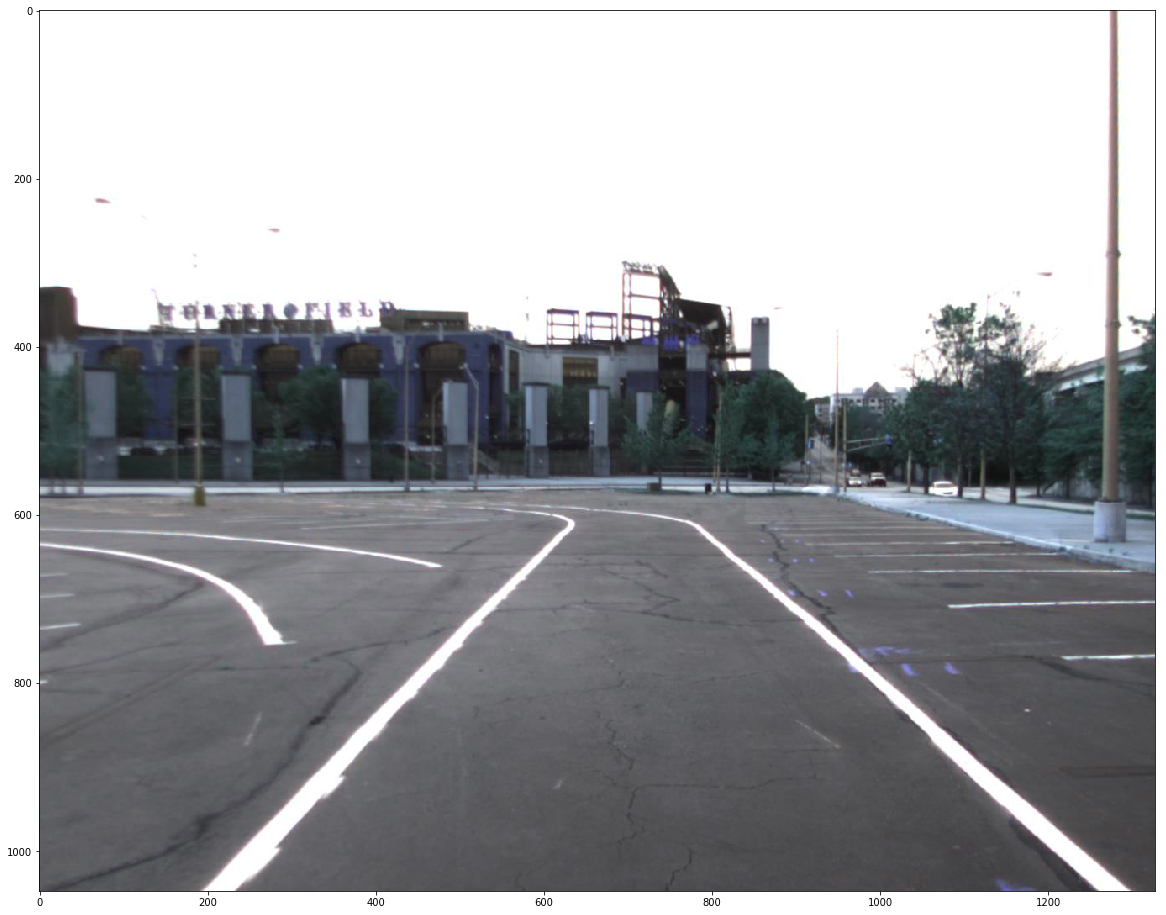

In [52]:
im_full = cv2.imread(path_to_training_images + '/' + str(int(10)).zfill(4) + '.jpg')
figure(0,(20,20))
imshow(im_full)

In [ ]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res